# Lab 3b

## Overview:
* [Part 1: Cross validation for parameter tuning, model selection, and feature selection](#Part-1:-Cross-validation-for-parameter-tuning,-model-selection,-and-feature-selection)
* [Part 2: Efficiently searching for optimal tuning parameters](#Part-2:-Efficiently-searching-for-optimal-tuning-parameters)
* [Part 3: Evaluating a classification model](#Part-3:-Evaluating-a-classification-model)

# Part 1: Cross-validation for parameter tuning, model selection, and feature selection
*From the video series: [Introduction to machine learning with scikit-learn](https://github.com/justmarkham/scikit-learn-videos)*

## Agenda

- What is the drawback of using the **train/test split** procedure for model evaluation?
- How does **K-fold cross-validation** overcome this limitation?
- How can cross-validation be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**?
- What are some possible **improvements** to cross-validation?

## Review of model evaluation procedures

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

In [90]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [91]:
# read in the iris data
iris = load_iris()

# create X (features) and y (response)
X = iris.data
y = iris.target

In [92]:
# use train/test split with different random_state values
# this demonstrates that the accuracy depends on which samples are used to train and test
for rs in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs)

    # check classification accuracy of KNN with K=5
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(metrics.accuracy_score(y_test, y_pred))

0.973684210526
1.0
1.0
0.947368421053
0.973684210526


**Question:** What if we created a bunch of train/test splits, calculated the testing accuracy for each, and averaged the results together?

**Answer:** That's the essense of cross-validation!

## Steps for K-fold cross-validation

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

Diagram of **5-fold cross-validation:**

![5-fold cross-validation](images/07_cross_validation_diagram.png)

In [93]:
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False)
splits = kf.split(X[:25])

# print the indices of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(splits, start=1):
    print('{!r:^9} {} {!r:^25}'.format(iteration, list(data[0]), list(data[1])))

Iteration                   Training set observations                   Testing set observations
    1     [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]      [0, 1, 2, 3, 4]     
    2     [0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]      [5, 6, 7, 8, 9]     
    3     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]   [10, 11, 12, 13, 14]   
    4     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24]   [15, 16, 17, 18, 19]   
    5     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]   [20, 21, 22, 23, 24]   


- Dataset contains **25 observations** (numbered 0 through 24)
- 5-fold cross-validation, thus it runs for **5 iterations**
- For each iteration, every observation is either in the training set or the testing set, **but not both**
- Every observation is in the testing set **exactly once**

## Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

## Cross-validation recommendations

1. K can be any number, but **K=10** is generally recommended
2. For classification problems, **stratified sampling** is recommended for creating the folds
    - Each response class should be represented with equal proportions in each of the K folds
    - scikit-learn's `cross_val_score` function does this by default

## Cross-validation example: parameter tuning

**Goal:** Select the best tuning parameters (aka "hyperparameters") for KNN on the iris dataset

In [94]:
from sklearn.model_selection import cross_val_score

In [95]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[ 1.          0.93333333  1.          1.          0.86666667  0.93333333
  0.93333333  1.          1.          1.        ]


In [96]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.966666666667


In [97]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)
max(zip(k_scores, k_range))

[0.95999999999999996, 0.95333333333333337, 0.96666666666666656, 0.96666666666666656, 0.96666666666666679, 0.96666666666666679, 0.96666666666666679, 0.96666666666666679, 0.97333333333333338, 0.96666666666666679, 0.96666666666666679, 0.97333333333333338, 0.98000000000000009, 0.97333333333333338, 0.97333333333333338, 0.97333333333333338, 0.97333333333333338, 0.98000000000000009, 0.97333333333333338, 0.98000000000000009, 0.96666666666666656, 0.96666666666666656, 0.97333333333333338, 0.95999999999999996, 0.96666666666666656, 0.95999999999999996, 0.96666666666666656, 0.95333333333333337, 0.95333333333333337, 0.95333333333333337]


(0.98000000000000009, 20)

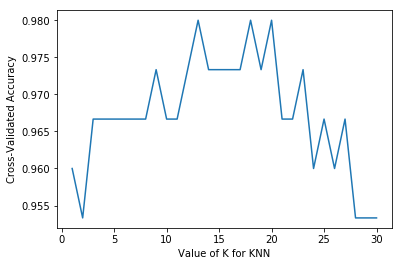

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## Cross-validation example: model selection

**Goal:** Compare the best KNN model with logistic regression on the iris dataset

In [99]:
# 10-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=20)
print(cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean())

0.98


__Task 1:__ Print the mean 10-fold cross validation score of the default logistic regression model.

In [100]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
# YOUR CODE HERE

0.953333333333


## Cross-validation example: feature selection

**Goal**: Select whether the Newspaper feature should be included in the linear regression model on the advertising dataset

In [101]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [102]:
# read in the advertising dataset
data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)

In [103]:
# create a Python list of three feature names
feature_cols = ['TV', 'radio', 'newspaper']

# use the list to select a subset of the DataFrame (X)
X = data[feature_cols]

# select the Sales column as the response (y)
y = data.sales

In [104]:
# 10-fold cross-validation with all three features
lm = LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring='neg_mean_squared_error')
print(scores)

[-3.56038438 -3.29767522 -2.08943356 -2.82474283 -1.3027754  -1.74163618
 -8.17338214 -2.11409746 -3.04273109 -2.45281793]


In [105]:
# fix the sign of MSE scores
mse_scores = -scores
print(mse_scores)

[ 3.56038438  3.29767522  2.08943356  2.82474283  1.3027754   1.74163618
  8.17338214  2.11409746  3.04273109  2.45281793]


In [106]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print(rmse_scores)

[ 1.88689808  1.81595022  1.44548731  1.68069713  1.14139187  1.31971064
  2.85891276  1.45399362  1.7443426   1.56614748]


In [107]:
# calculate the average RMSE
print(rmse_scores.mean())

1.69135317081


__Task 2:__ Evaluate the model instead on all features but Newspaper. To do so, Compute the _average root mean squared error (RMSE)_ of the 10-fold cross validation scores.

In [108]:
# 10-fold cross-validation with two features (excluding Newspaper)
feature_cols = ['TV', 'radio']
X = data[feature_cols]
# YOUR CODE HERE
print(avg_rmse)
assert 1 < avg_rmse < 2

1.67967484191


## Improvements to cross-validation

**Repeated cross-validation**

- Repeat cross-validation multiple times (with **different random splits** of the data) and average the results
- More reliable estimate of out-of-sample performance by **reducing the variance** associated with a single trial of cross-validation

**Creating a hold-out set**

- "Hold out" a portion of the data **before** beginning the model building process
- Locate the best model using cross-validation on the remaining data, and test it **using the hold-out set**
- More reliable estimate of out-of-sample performance since hold-out set is **truly out-of-sample**

**Feature engineering and selection within cross-validation iterations**

- Normally, feature engineering and selection occurs **before** cross-validation
- Instead, perform all feature engineering and selection **within each cross-validation iteration**
- More reliable estimate of out-of-sample performance since it **better mimics** the application of the model to out-of-sample data

## Resources

- scikit-learn documentation: [Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html), [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- scikit-learn issue on GitHub: [MSE is negative when returned by cross_val_score](https://github.com/scikit-learn/scikit-learn/issues/2439)
- Section 5.1 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) (11 pages) and related videos: [K-fold and leave-one-out cross-validation](https://www.youtube.com/watch?v=nZAM5OXrktY) (14 minutes), [Cross-validation the right and wrong ways](https://www.youtube.com/watch?v=S06JpVoNaA0) (10 minutes)
- Scott Fortmann-Roe: [Accurately Measuring Model Prediction Error](http://scott.fortmann-roe.com/docs/MeasuringError.html)
- Machine Learning Mastery: [An Introduction to Feature Selection](http://machinelearningmastery.com/an-introduction-to-feature-selection/)
- Harvard CS109: [Cross-Validation: The Right and Wrong Way](https://github.com/cs109/content/blob/master/lec_10_cross_val.ipynb)
- Journal of Cheminformatics: [Cross-validation pitfalls when selecting and assessing regression and classification models](http://www.jcheminf.com/content/pdf/1758-2946-6-10.pdf)

# Part 2: Efficiently searching for optimal tuning parameters
*From the video series: [Introduction to machine learning with scikit-learn](https://github.com/justmarkham/scikit-learn-videos)*

## Agenda

- How can K-fold cross-validation be used to search for an **optimal tuning parameter**?
- How can this process be made **more efficient**?
- How do you search for **multiple tuning parameters** at once?
- What do you do with those tuning parameters before making **real predictions**?
- How can the **computational expense** of this process be reduced?

## Review of K-fold cross-validation

Steps for cross-validation:

- Dataset is split into K "folds" of **equal size**
- Each fold acts as the **testing set** 1 time, and acts as the **training set** K-1 times
- **Average testing performance** is used as the estimate of out-of-sample performance

Benefits of cross-validation:

- More **reliable** estimate of out-of-sample performance than train/test split
- Can be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**

Drawbacks of cross-validation:

- Can be computationally **expensive**

## Review of parameter tuning using `cross_val_score`

**Goal:** Select the best tuning parameters (aka "hyperparameters") for KNN on the iris dataset

In [109]:
X = iris.data
y = iris.target

__Task 3: __ Instantiate a KNN model with K=5 and print the 10-fold cross val scores.

In [110]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
# YOUR CODE HERE
print(scores)

[ 1.          0.93333333  1.          1.          0.86666667  0.93333333
  0.93333333  1.          1.          1.        ]


In [111]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.966666666667


In [112]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.95999999999999996, 0.95333333333333337, 0.96666666666666656, 0.96666666666666656, 0.96666666666666679, 0.96666666666666679, 0.96666666666666679, 0.96666666666666679, 0.97333333333333338, 0.96666666666666679, 0.96666666666666679, 0.97333333333333338, 0.98000000000000009, 0.97333333333333338, 0.97333333333333338, 0.97333333333333338, 0.97333333333333338, 0.98000000000000009, 0.97333333333333338, 0.98000000000000009, 0.96666666666666656, 0.96666666666666656, 0.97333333333333338, 0.95999999999999996, 0.96666666666666656, 0.95999999999999996, 0.96666666666666656, 0.95333333333333337, 0.95333333333333337, 0.95333333333333337]


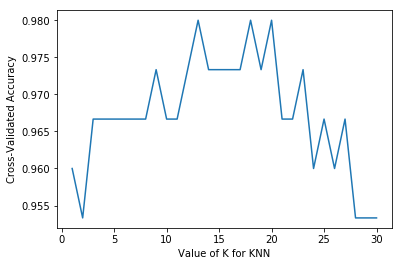

In [113]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## More efficient parameter tuning using `GridSearchCV`

Allows you to define a **grid of parameters** that will be **searched** using K-fold cross-validation

In [114]:
from sklearn.model_selection import GridSearchCV

In [115]:
# define the parameter values that should be searched
k_range = list(range(1, 31))
print(k_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [116]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


In [117]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

- You can set **`n_jobs = -1`** to run computations in parallel (if supported by your computer and OS)

In [118]:
# fit the grid with data
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [119]:
# view the complete results (list of named tuples)
# Ignore the deprecation warning, it's just a warning
grid.grid_scores_

/Users/lukezhu/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.96000, std: 0.05333, params: {'n_neighbors': 1},
 mean: 0.95333, std: 0.05207, params: {'n_neighbors': 2},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 3},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 4},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 5},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 6},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 7},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 8},
 mean: 0.97333, std: 0.03266, params: {'n_neighbors': 9},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 10},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 11},
 mean: 0.97333, std: 0.03266, params: {'n_neighbors': 12},
 mean: 0.98000, std: 0.03055, params: {'n_neighbors': 13},
 mean: 0.97333, std: 0.04422, params: {'n_neighbors': 14},
 mean: 0.97333, std: 0.03266, params: {'n_neighbors': 15},
 mean: 0.97333, std: 0.03266, params: {'n_neighbors': 16},
 mean: 0.97333, std: 0.03266, params: {'n_neighbors': 17},
 mean:

In [120]:
# examine the first tuple
print(grid.grid_scores_[0].parameters)
print(grid.grid_scores_[0].cv_validation_scores)
print(grid.grid_scores_[0].mean_validation_score)

{'n_neighbors': 1}
[ 1.          0.93333333  1.          0.93333333  0.86666667  1.
  0.86666667  1.          1.          1.        ]
0.96


/Users/lukezhu/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/lukezhu/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/lukezhu/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


__Task 4:__ Now that you've seen how to access the values in each tuple, create a 1-D list of all mean validation scores.

In [127]:
# create a list of the mean scores only
# YOUR CODE HERE

assert len(grid_mean_scores) == 30
assert isinstance(grid_mean_scores[0], np.float)

[0.95999999999999996, 0.95333333333333337, 0.96666666666666667, 0.96666666666666667, 0.96666666666666667, 0.96666666666666667, 0.96666666666666667, 0.96666666666666667, 0.97333333333333338, 0.96666666666666667, 0.96666666666666667, 0.97333333333333338, 0.97999999999999998, 0.97333333333333338, 0.97333333333333338, 0.97333333333333338, 0.97333333333333338, 0.97999999999999998, 0.97333333333333338, 0.97999999999999998, 0.96666666666666667, 0.96666666666666667, 0.97333333333333338, 0.95999999999999996, 0.96666666666666667, 0.95999999999999996, 0.96666666666666667, 0.95333333333333337, 0.95333333333333337, 0.95333333333333337]


/Users/lukezhu/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [ ]:
# plot the results
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

## Searching multiple parameters simultaneously

- **Example:** tuning `max_depth` and `min_samples_leaf` for a `DecisionTreeClassifier`
- Could tune parameters **independently**: change `max_depth` while leaving `min_samples_leaf` at its default value, and vice versa
- But, best performance might be achieved when **neither parameter** is at its default value

In [ ]:
# define the parameter values that should be searched
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']

In [ ]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

In [ ]:
# instantiate and fit the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)

In [ ]:
# view the complete results
grid.grid_scores_

In [ ]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)

## Using the best parameters to make predictions

In [ ]:
# train your model using all data and the best known parameters
knn = KNeighborsClassifier(n_neighbors=13, weights='uniform')
knn.fit(X, y)

# make a prediction on out-of-sample data
knn.predict([[3, 5, 4, 2]])

In [ ]:
# shortcut: GridSearchCV automatically refits the best model using all of the data
grid.predict([[3, 5, 4, 2]])

## Reducing computational expense using `RandomizedSearchCV`

- Searching many different parameters at once may be computationally infeasible
- `RandomizedSearchCV` searches a subset of the parameters, and you control the computational "budget"

In [ ]:
from sklearn.grid_search import RandomizedSearchCV

In [ ]:
# specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options)

- **Important:** Specify a continuous distribution (rather than a list of values) for any continous parameters

In [ ]:
# n_iter controls the number of searches
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(X, y)
rand.grid_scores_

In [ ]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

In [ ]:
# run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
best_scores = []
for _ in range(20):
    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10)
    rand.fit(X, y)
    best_scores.append(round(rand.best_score_, 3))
print(best_scores)

## Resources

- scikit-learn documentation: [Grid search](http://scikit-learn.org/stable/modules/grid_search.html), [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html), [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html)
- Timed example: [Comparing randomized search and grid search](http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html)
- scikit-learn workshop by Andreas Mueller: [Video segment on randomized search](https://youtu.be/0wUF_Ov8b0A?t=17m38s) (3 minutes), [related notebook](https://github.com/amueller/pydata-nyc-advanced-sklearn/blob/master/Chapter%203%20-%20Randomized%20Hyper%20Parameter%20Search.ipynb)
- Paper by Yoshua Bengio: [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)

# Part 3: Evaluating a classification model

*From the video series: [Introduction to machine learning with scikit-learn](https://github.com/justmarkham/scikit-learn-videos)*

## Agenda

- What is the purpose of **model evaluation**, and what are some common evaluation procedures?
- What is the usage of **classification accuracy**, and what are its limitations?
- How does a **confusion matrix** describe the performance of a classifier?
- What **metrics** can be computed from a confusion matrix?
- How can you adjust classifier performance by **changing the classification threshold**?
- What is the purpose of an **ROC curve**?
- How does **Area Under the Curve (AUC)** differ from classification accuracy?

## Review of model evaluation

- Need a way to choose between models: different model types, tuning parameters, and features
- Use a **model evaluation procedure** to estimate how well a model will generalize to out-of-sample data
- Requires a **model evaluation metric** to quantify the model performance

### Model evaluation procedures

1. **Training and testing on the same data**
    - Rewards overly complex models that "overfit" the training data and won't necessarily generalize
2. **Train/test split**
    - Split the dataset into two pieces, so that the model can be trained and tested on different data
    - Better estimate of out-of-sample performance, but still a "high variance" estimate
    - Useful due to its speed, simplicity, and flexibility
3. **K-fold cross-validation**
    - Systematically create "K" train/test splits and average the results together
    - Even better estimate of out-of-sample performance
    - Runs "K" times slower than train/test split

### Model evaluation metrics

- **Regression problems:** Mean Absolute Error, Mean Squared Error, Root Mean Squared Error
- **Classification problems:** Classification accuracy

## Classification accuracy

[Pima Indian Diabetes dataset](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) from the UCI Machine Learning Repository

In [ ]:
# read the data into a Pandas DataFrame
import pandas as pd
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv(url, header=None, names=col_names)

In [ ]:
# print the first 5 rows of data
pima.head()

**Question:** Can we predict the diabetes status of a patient given their health measurements?

In [ ]:
# define X and y
feature_cols = ['pregnant', 'insulin', 'bmi', 'age']
X = pima[feature_cols]
y = pima.label

In [ ]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

**Classification accuracy:** percentage of correct predictions

In [ ]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

**Null accuracy:** accuracy that could be achieved by always predicting the most frequent class

In [ ]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

In [ ]:
# calculate the percentage of ones
y_test.mean()

In [ ]:
# calculate the percentage of zeros
1 - y_test.mean()

In [ ]:
# calculate null accuracy (for binary classification problems coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

In [ ]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(1) / len(y_test)

Comparing the **true** and **predicted** response values

In [ ]:
# print the first 25 true and predicted responses
from __future__ import print_function
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

**Conclusion:**

- Classification accuracy is the **easiest classification metric to understand**
- But, it does not tell you the **underlying distribution** of response values
- And, it does not tell you what **"types" of errors** your classifier is making

## Confusion matrix

Table that describes the performance of a classification model

In [ ]:
# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

![Small confusion matrix](images/09_confusion_matrix_1.png)

- Every observation in the testing set is represented in **exactly one box**
- It's a 2x2 matrix because there are **2 response classes**
- The format shown here is **not** universal

**Basic terminology**

- **True Positives (TP):** we *correctly* predicted that they *do* have diabetes
- **True Negatives (TN):** we *correctly* predicted that they *don't* have diabetes
- **False Positives (FP):** we *incorrectly* predicted that they *do* have diabetes (a "Type I error")
- **False Negatives (FN):** we *incorrectly* predicted that they *don't* have diabetes (a "Type II error")

In [ ]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

In [ ]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

![Large confusion matrix](images/09_confusion_matrix_2.png)

## Metrics computed from a confusion matrix

**Classification Accuracy:** Overall, how often is the classifier correct?

In [ ]:
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

**Classification Error:** Overall, how often is the classifier incorrect?

- Also known as "Misclassification Rate"

In [ ]:
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

**Sensitivity:** When the actual value is positive, how often is the prediction correct?

- How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"

In [ ]:
print(TP / float(TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

**Specificity:** When the actual value is negative, how often is the prediction correct?

- How "specific" (or "selective") is the classifier in predicting positive instances?

In [ ]:
print(TN / float(TN + FP))

**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?

In [ ]:
print(FP / float(TN + FP))

**Precision:** When a positive value is predicted, how often is the prediction correct?

- How "precise" is the classifier when predicting positive instances?

In [ ]:
print(TP / float(TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

Many other metrics can be computed: F1 score, Matthews correlation coefficient, etc.

**Conclusion:**

- Confusion matrix gives you a **more complete picture** of how your classifier is performing
- Also allows you to compute various **classification metrics**, and these metrics can guide your model selection

**Which metrics should you focus on?**

- Choice of metric depends on your **business objective**
- **Spam filter** (positive class is "spam"): Optimize for **precision or specificity** because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)
- **Fraudulent transaction detector** (positive class is "fraud"): Optimize for **sensitivity** because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

## Adjusting the classification threshold

In [ ]:
# print the first 10 predicted responses
logreg.predict(X_test)[0:10]

In [ ]:
# print the first 10 predicted probabilities of class membership
logreg.predict_proba(X_test)[0:10, :]

In [ ]:
# print the first 10 predicted probabilities for class 1
logreg.predict_proba(X_test)[0:10, 1]

In [ ]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [ ]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

In [ ]:
# histogram of predicted probabilities
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

**Decrease the threshold** for predicting diabetes in order to **increase the sensitivity** of the classifier

In [ ]:
# predict diabetes if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_prob], 0.3)[0]

In [ ]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

In [ ]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

In [ ]:
# previous confusion matrix (default threshold of 0.5)
print(confusion)

In [ ]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(y_test, y_pred_class))

In [ ]:
# sensitivity has increased (used to be 0.24)
print(46 / float(46 + 16))

In [ ]:
# specificity has decreased (used to be 0.91)
print(80 / float(80 + 50))

**Conclusion:**

- **Threshold of 0.5** is used by default (for binary problems) to convert predicted probabilities into class predictions
- Threshold can be **adjusted** to increase sensitivity or specificity
- Sensitivity and specificity have an **inverse relationship**

## ROC Curves and Area Under the Curve (AUC)

**Question:** Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?

**Answer:** Plot the ROC curve!

In [ ]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

- ROC curve can help you to **choose a threshold** that balances sensitivity and specificity in a way that makes sense for your particular context
- You can't actually **see the thresholds** used to generate the curve on the ROC curve itself

In [ ]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [ ]:
evaluate_threshold(0.5)

In [ ]:
evaluate_threshold(0.3)

AUC is the **percentage** of the ROC plot that is **underneath the curve**:

In [ ]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, y_pred_prob))

- AUC is useful as a **single number summary** of classifier performance.
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a **higher predicted probability** to the positive observation.
- AUC is useful even when there is **high class imbalance** (unlike classification accuracy).

In [ ]:
# calculate cross-validated AUC
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

**Confusion matrix advantages:**

- Allows you to calculate a **variety of metrics**
- Useful for **multi-class problems** (more than two response classes)

**ROC/AUC advantages:**

- Does not require you to **set a classification threshold**
- Still useful when there is **high class imbalance**

## Confusion Matrix Resources

- Blog post: [Simple guide to confusion matrix terminology](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by me
- Videos: [Intuitive sensitivity and specificity](https://www.youtube.com/watch?v=U4_3fditnWg) (9 minutes) and [The tradeoff between sensitivity and specificity](https://www.youtube.com/watch?v=vtYDyGGeQyo) (13 minutes) by Rahul Patwari
- Notebook: [How to calculate "expected value"](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb) from a confusion matrix by treating it as a cost-benefit matrix (by Ed Podojil)
- Graphic: How [classification threshold](https://media.amazonwebservices.com/blog/2015/ml_adjust_model_1.png) affects different evaluation metrics (from a [blog post](https://aws.amazon.com/blogs/aws/amazon-machine-learning-make-data-driven-decisions-at-scale/) about Amazon Machine Learning)


## ROC and AUC Resources

- Lesson notes: [ROC Curves](http://ebp.uga.edu/courses/Chapter%204%20-%20Diagnosis%20I/8%20-%20ROC%20curves.html) (from the University of Georgia)
- Video: [ROC Curves and Area Under the Curve](https://www.youtube.com/watch?v=OAl6eAyP-yo) (14 minutes) by me, including [transcript and screenshots](http://www.dataschool.io/roc-curves-and-auc-explained/) and a [visualization](http://www.navan.name/roc/)
- Video: [ROC Curves](https://www.youtube.com/watch?v=21Igj5Pr6u4) (12 minutes) by Rahul Patwari
- Paper: [An introduction to ROC analysis](http://people.inf.elte.hu/kiss/13dwhdm/roc.pdf) by Tom Fawcett
- Usage examples: [Comparing different feature sets](http://research.microsoft.com/pubs/205472/aisec10-leontjeva.pdf) for detecting fraudulent Skype users, and [comparing different classifiers](http://www.cse.ust.hk/nevinZhangGroup/readings/yi/Bradley_PR97.pdf) on a number of popular datasets

## Other Resources

- scikit-learn documentation: [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- Guide: [Comparing model evaluation procedures and metrics](https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md) by me
- Video: [Counterfactual evaluation of machine learning models](https://www.youtube.com/watch?v=QWCSxAKR-h0) (45 minutes) about how Stripe evaluates its fraud detection model, including [slides](http://www.slideshare.net/MichaelManapat/counterfactual-evaluation-of-machine-learning-models)